In [1]:
# Main evaluation function for binary classification
def evaluate_binary_classification(prediction_data, ground_truth, prediction_col, truth_col='malignancy', 
                                  pos_label='malignant', neg_label='non-malignant', 
                                  compute_umap=True, plot_umap=True, random_state=42, load_path="../umap_embeddings",
                                  save_path="../umap_embeddings"):
    """
    Evaluate binary classification results against ground truth.
    
    Parameters:
    -----------
    prediction_data : AnnData
        The prediction dataset
    ground_truth : AnnData
        The ground truth dataset
    prediction_col : str
        The column in prediction_data.obs containing the predictions
    truth_col : str
        The column in ground_truth.obs containing the ground truth labels
    pos_label : str
        The value representing the positive class
    neg_label : str
        The value representing the negative class
    compute_umap : bool
        Whether to compute UMAP coordinates if not present
    plot_umap : bool
        Whether to plot UMAP visualizations
    random_state : int
        Random seed for reproducible UMAP results (default: 42)
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Check that required columns exist
    if prediction_col not in prediction_data.obs.columns:
        raise ValueError(f"Column '{prediction_col}' not found in prediction data")
    if truth_col not in ground_truth.obs.columns:
        raise ValueError(f"Column '{truth_col}' not found in ground truth data")
    
    # Align datasets
    prediction_subset, ground_truth_subset = align_datasets(prediction_data, ground_truth)
    
    # Get raw labels
    true_raw = ground_truth_subset.obs[truth_col]
    pred_raw = prediction_subset.obs[prediction_col]
    
    # Convert to binary format if not already
    true_bin = np.where(true_raw == pos_label, pos_label, neg_label)
    pred_bin = np.where(pred_raw == pos_label, pos_label, neg_label)
    
    # Sanity check
    print("True labels:", np.unique(true_bin))
    print("Pred labels:", np.unique(pred_bin))
    
    # Compute metrics
    cm = confusion_matrix(true_bin, pred_bin, labels=[pos_label, neg_label])
    accuracy = accuracy_score(true_bin, pred_bin)
    precision = precision_score(true_bin, pred_bin, pos_label=pos_label)
    recall = recall_score(true_bin, pred_bin, pos_label=pos_label)
    f1 = f1_score(true_bin, pred_bin, pos_label=pos_label)
    
    # Print results
    print(f"\nBinary Classification Results ({pos_label} vs {neg_label}):")
    print("\nConfusion Matrix:\n", cm)
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    # Full classification report
    print("\nClassification Report:")
    print(classification_report(
        true_bin, pred_bin,
        labels=[pos_label, neg_label],
        target_names=[pos_label, neg_label]
    ))
    
        # Use the new unified UMAP function with fixed random state
    if compute_umap:
        # Use the new unified UMAP function
        prediction_subset, ground_truth_subset = compute_unified_umap(
            prediction_subset, 
            ground_truth_subset,
            prediction_col,
            truth_col,
            random_state=random_state,
            load_path=load_path,
            save_path=save_path
        )
    
    if plot_umap and 'X_umap' in prediction_subset.obsm and 'X_umap' in ground_truth_subset.obsm:
        # Create binary label columns for visualization
        ground_truth_subset.obs['binary_truth'] = true_bin
        prediction_subset.obs['binary_pred'] = pred_bin
        
        # Using scanpy's plotting with axes - create two rows of plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # First row: Original labels
        # sc.pl.umap(ground_truth_subset, color=truth_col, show=False, title='Ground Truth (Original)', ax=axes[0, 0])
        # sc.pl.umap(prediction_subset, color=prediction_col, show=False, title='Prediction (Original)', ax=axes[0, 1])
        
        # Second row: Binary classification
        sc.pl.umap(ground_truth_subset, color='binary_truth', show=False, title='Ground Truth (Binary)', ax=axes[0])
        sc.pl.umap(prediction_subset, color='binary_pred', show=False, title='Prediction (Binary)', ax=axes[1])

        plt.tight_layout()
        plt.show()
    elif plot_umap:
        print("UMAP coordinates not available for visualization")
    
    # Return metrics as dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }
    

    return metrics

In [2]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Utility function to align datasets based on common cells
def align_datasets(prediction_data, ground_truth):
    """
    Align prediction and ground truth datasets based on common cell IDs.
    
    Parameters:
    -----------
    prediction_data : AnnData
        The prediction dataset
    ground_truth : AnnData
        The ground truth dataset
        
    Returns:
    --------
    tuple
        (aligned_prediction, aligned_ground_truth)
    """
    common_cells = set(prediction_data.obs_names) & set(ground_truth.obs_names)
    if len(common_cells) == 0:
        raise ValueError("No common cells found between prediction and ground truth datasets")
    
    print(f"Found {len(common_cells)} common cells between datasets")
    
    # Important: Sort the common cells to ensure consistent ordering
    common_cells = sorted(list(common_cells))
    
    prediction_subset = prediction_data[common_cells]
    ground_truth_subset = ground_truth[common_cells]
    
    return prediction_subset, ground_truth_subset

# Function to compute UMAP if not already present
def ensure_umap(adata, label="dataset", random_state=42):
    """
    Ensure UMAP coordinates are available in the dataset.
    
    Parameters:
    -----------
    adata : AnnData
        The dataset to ensure UMAP for
    label : str
        Label for progress messages
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    AnnData
        The dataset with UMAP coordinates
    """
    if 'X_umap' not in adata.obsm:
        print(f"Computing UMAP for {label}...")
        if 'X_pca' not in adata.obsm:
            sc.pp.pca(adata, random_state=random_state)
        sc.pp.neighbors(adata, random_state=random_state)
        sc.tl.umap(adata, random_state=random_state)
    
    return adata

# Add this function to save and load UMAP embeddings
def save_load_umap_embeddings(prediction_data, ground_truth, save_path=None, load_path=None):
    """
    Save or load UMAP embeddings for prediction and ground truth data.
    
    Parameters:
    -----------
    prediction_data : AnnData
        The prediction dataset
    ground_truth : AnnData
        The ground truth dataset
    save_path : str, optional
        Path to save UMAP embeddings
    load_path : str, optional
        Path to load UMAP embeddings from
        
    Returns:
    --------
    tuple or None
        If loading, returns (prediction_data, ground_truth) with loaded embeddings
        If saving, returns None
    """
    import os
    import numpy as np
    
    if load_path and os.path.exists(f"{load_path}_pred.npy") and os.path.exists(f"{load_path}_truth.npy"):
        print(f"Loading UMAP embeddings from {load_path}")
        try:
            pred_umap = np.load(f"{load_path}_pred.npy")
            truth_umap = np.load(f"{load_path}_truth.npy")
            
            # Check if the cell counts match
            if pred_umap.shape[0] == prediction_data.n_obs and truth_umap.shape[0] == ground_truth.n_obs:
                prediction_data.obsm['X_umap'] = pred_umap
                ground_truth.obsm['X_umap'] = truth_umap
                print("UMAP embeddings successfully loaded")
                return prediction_data, ground_truth
            else:
                print("Warning: Saved UMAP dimensions don't match current data dimensions")
                return None
        except Exception as e:
            print(f"Error loading UMAP embeddings: {str(e)}")
            return None
    
    if save_path and 'X_umap' in prediction_data.obsm and 'X_umap' in ground_truth.obsm:
        try:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            np.save(f"{save_path}_pred.npy", prediction_data.obsm['X_umap'])
            np.save(f"{save_path}_truth.npy", ground_truth.obsm['X_umap'])
            print(f"UMAP embeddings saved to {save_path}")
        except Exception as e:
            print(f"Error saving UMAP embeddings: {str(e)}")
    
    return None

# Modify the compute_unified_umap function to include loading/saving
def compute_unified_umap(prediction_subset, ground_truth_subset, prediction_col, truth_col, 
                        random_state=42, load_path=None, save_path=None):
    """
    Compute a unified UMAP embedding for both prediction and ground truth datasets.
    Will load from disk if available or save to disk if requested.
    
    Parameters:
    -----------
    prediction_subset : AnnData
        The aligned prediction dataset
    ground_truth_subset : AnnData
        The aligned ground truth dataset
    prediction_col : str
        The column in prediction_subset.obs containing predictions
    truth_col : str
        The column in ground_truth_subset.obs containing ground truth
    random_state : int
        Random seed for reproducibility
    load_path : str, optional
        Path to load UMAP embeddings from
    save_path : str, optional
        Path to save UMAP embeddings to
        
    Returns:
    --------
    tuple
        (prediction_with_umap, ground_truth_with_umap)
    """
    # Try loading embeddings first if path provided
    if load_path:
        result = save_load_umap_embeddings(prediction_subset, ground_truth_subset, load_path=load_path)
        if result is not None:
            return result
    
    print("Computing unified UMAP for both datasets...")
    
    # The rest of your existing UMAP computation code...
    
    # Create a copy to avoid modifying the original data
    pred_copy = prediction_subset.copy()
    truth_copy = ground_truth_subset.copy()
    
    # Add dataset origin as obs column
    pred_copy.obs['dataset'] = 'prediction'
    truth_copy.obs['dataset'] = 'ground_truth'
    
    # Ensure identical vars
    common_vars = list(set(pred_copy.var_names) & set(truth_copy.var_names))
    if len(common_vars) == 0:
        print("Warning: No common genes found, unified UMAP may not be meaningful")
        # Fall back to separate UMAP if needed
        return ensure_umap(pred_copy, random_state=random_state), ensure_umap(truth_copy, random_state=random_state)
    
    print(f"Using {len(common_vars)} common genes for unified UMAP")
    
    # Subset to common vars
    pred_copy = pred_copy[:, common_vars]
    truth_copy = truth_copy[:, common_vars]
    
    # Concatenate datasets
    combined = pred_copy.concatenate(truth_copy)
    
    # Normalize data if needed
    sc.pp.normalize_total(combined, target_sum=1e4)
    sc.pp.log1p(combined)
    
    # Compute UMAP on combined data with fixed random state
    
    print("Computing PCA on combined dataset...")
    sc.pp.pca(combined, random_state=random_state)
    
    # print("Computing neighbors graph...")
    # sc.pp.neighbors(combined, random_state=random_state, n_neighbors=15)
    
    # print("Computing UMAP embedding...")
    # sc.tl.umap(combined, random_state=random_state, min_dist=0.1)

    # Use direct UMAP implementation with n_jobs
    print("Computing UMAP embedding...")
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=random_state,
        n_jobs=16,  # Use multiple cores
        low_memory=False  # Faster but more memory usage
    )
    combined.obsm['X_umap'] = reducer.fit_transform(combined.obsm['X_pca'])
    
    # Split back into prediction and ground truth
    pred_idx = combined.obs['dataset'] == 'prediction'
    truth_idx = combined.obs['dataset'] == 'ground_truth'
    
    # Get the embeddings
    pred_umap = combined[pred_idx].obsm['X_umap']
    truth_umap = combined[truth_idx].obsm['X_umap']
    
    # Add the embeddings back to the original data
    pred_copy.obsm['X_umap'] = pred_umap
    truth_copy.obsm['X_umap'] = truth_umap
    
    # Make sure they have the exact same cells in same order
    assert all(pred_copy.obs_names == truth_copy.obs_names), "Cell ordering mismatch after UMAP computation"
    
    print("Unified UMAP embedding complete")
    
    # Save embeddings if path provided
    if save_path:
        save_load_umap_embeddings(pred_copy, truth_copy, save_path=save_path)
    
    return pred_copy, truth_copy

/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[ 5481 80268]
 [  468 52510]]
Accuracy : 0.4180
Precision: 0.9213
Recall   : 0.0639
F1 Score : 0.1195

Classification Report:
               precision    recall  f1-score   support

    malignant       0.92      0.06      0.12     85749
non-malignant       0.40      0.99      0.57     52978

     accuracy                           0.42    138727
    macro avg       0.66      0.53      0.34    138727
 weighted avg       0.72      0.42      0.29    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset
Computing unified UMAP for both datasets...
Using 33541 common genes for unified UMAP


/tmp/ipykernel_1961995/2042606192.py:190: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined = pred_copy.concatenate(truth_copy)


Computing PCA on combined dataset...
Computing UMAP embedding...


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1961995/2042606192.py:228: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  pred_copy.obsm['X_umap'] = pred_umap
/tmp/ipykernel_1961995/2042606192.py:229: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  truth_copy.obsm['X_umap'] = truth_umap


Unified UMAP embedding complete
UMAP embeddings saved to ../umap_embeddings/biomaster_dataset


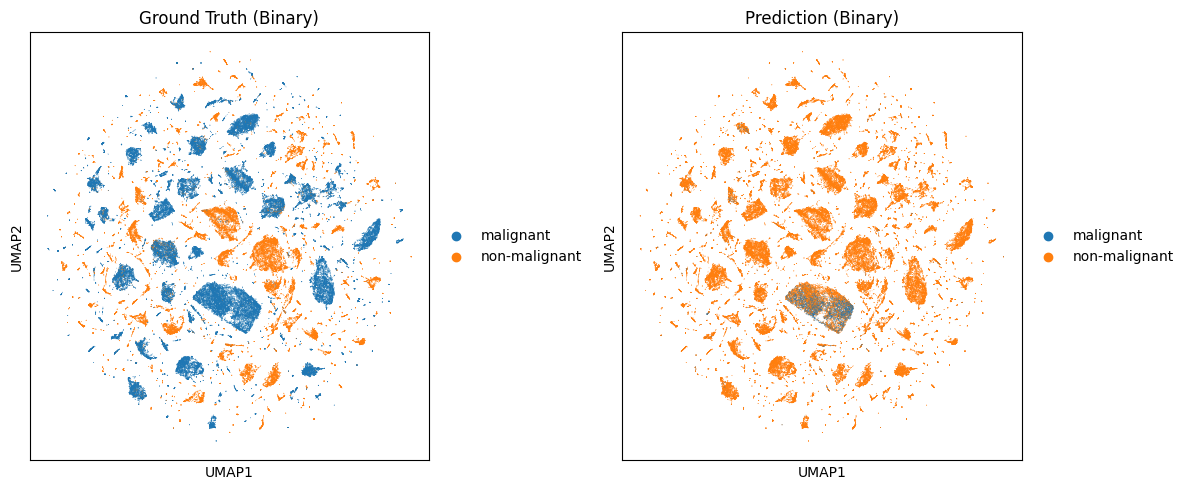

In [5]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/biomaster/output/o3_full_dataset/annotated_cells_fixed_obs_names.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
prediction_data = sc.read_h5ad(prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

# Use a unique path for this specific dataset combination
umap_path = "../umap_embeddings/biomaster_dataset"

# First, try loading existing embeddings
metrics = evaluate_binary_classification(
        prediction_data=prediction_data,
        ground_truth=ground_truth,
        prediction_col="cell_type",  # Change this to match your prediction column
        truth_col="malignancy",
        load_path=umap_path,
        save_path=umap_path,
        compute_umap=True,  # Set to False if you don't need UMAP
        plot_umap=True  # Set to False if you don't want to plot
    )

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[12719 73030]
 [18010 34968]]
Accuracy : 0.3437
Precision: 0.4139
Recall   : 0.1483
F1 Score : 0.2184

Classification Report:
               precision    recall  f1-score   support

    malignant       0.41      0.15      0.22     85749
non-malignant       0.32      0.66      0.43     52978

     accuracy                           0.34    138727
    macro avg       0.37      0.40      0.33    138727
 weighted avg       0.38      0.34      0.30    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_111628/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_111628/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


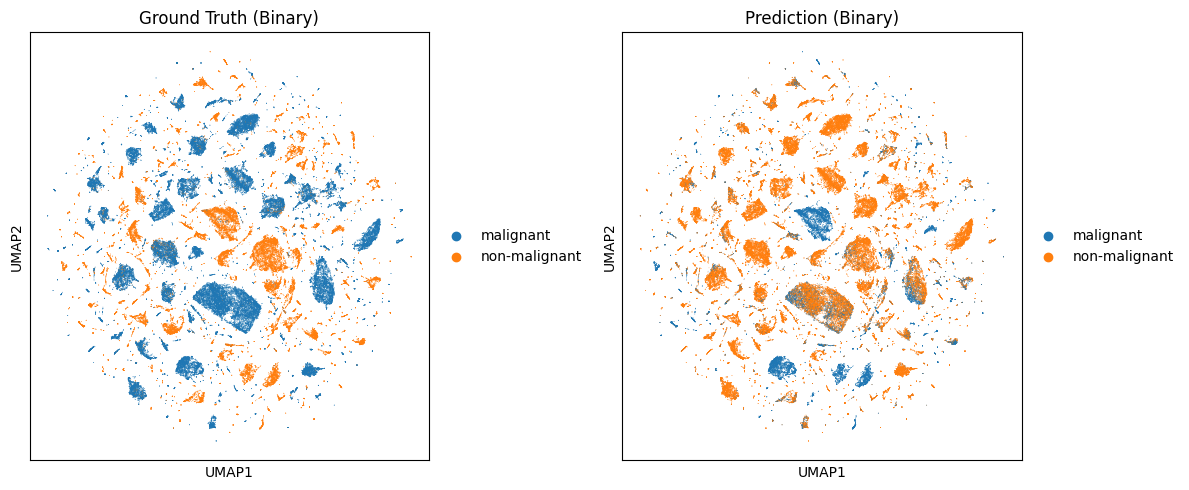

In [ ]:
# biomaster with plan

prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/biomaster/output/o3_plan/malignancy_classification.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
prediction_data = sc.read_h5ad(prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

# Use a unique path for this specific dataset combination
umap_path = "../umap_embeddings/biomaster_dataset"

# First, try loading existing embeddings
metrics = evaluate_binary_classification(
        prediction_data=prediction_data,
        ground_truth=ground_truth,
        prediction_col="malignant",  # Change this to match your prediction column
        truth_col="malignancy",
        load_path=umap_path,
        save_path=umap_path,
        compute_umap=True,  # Set to False if you don't need UMAP
        plot_umap=True  # Set to False if you don't want to plot
    )

# mllmcelltype

In [3]:
def map_cell_types_to_binary(adata, cell_type_col, malignant_types=None):
    """
    Maps cell types to binary categories (malignant/non-malignant).
    
    Parameters:
    -----------
    adata : AnnData
        The dataset containing cell type annotations
    cell_type_col : str
        The column in adata.obs containing the cell type annotations
    malignant_types : list, optional
        List of cell type strings to classify as malignant
        If None, uses a default list ['epithelial cell', 'epithelial cells', 
                                     'proliferating cell', 'proliferating cells']
    
    Returns:
    --------
    AnnData
        The input dataset with a new binary column 'cell_type_binary'
    """
    # Create a copy of the AnnData object to avoid modifying the original
    adata_copy = adata.copy()
    
    # Default malignant types if not provided
    if malignant_types is None:
        malignant_types = [
            # 'epithelial cell', 'epithelial cells',
            'proliferating cell', 'proliferating cells'
        ]
    
    # Check that required column exists
    if cell_type_col not in adata_copy.obs.columns:
        raise ValueError(f"Column '{cell_type_col}' not found in the provided dataset")
    
    # Create new binary column
    binary_col = f"{cell_type_col}_binary"
    
    # Initialize all as non-malignant
    adata_copy.obs[binary_col] = 'non-malignant'
    
    # Count before classification
    print(f"Before classification: {len(adata_copy)} cells total")
    
    # Map cell types to malignant if they match any in the malignant_types list
    for malignant_type in malignant_types:
        mask = adata_copy.obs[cell_type_col].str.lower().str.contains(malignant_type, na=False)
        adata_copy.obs.loc[mask, binary_col] = 'malignant'
    
    # Print the distribution of binary categories
    print("\nBinary category distribution:")
    print(adata_copy.obs[binary_col].value_counts())
    
    # Calculate percentage of malignant cells
    malignant_count = adata_copy.obs[binary_col].value_counts().get('malignant', 0)
    malignant_percent = (malignant_count / len(adata_copy)) * 100
    print(f"Malignant cells: {malignant_count} ({malignant_percent:.2f}%)")
    
    return adata_copy

Before classification: 138727 cells total

Binary category distribution:
gpt4o_cell_type_binary
non-malignant    123969
malignant         14758
Name: count, dtype: int64
Malignant cells: 14758 (10.64%)
Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[14736 71013]
 [   22 52956]]
Accuracy : 0.4880
Precision: 0.9985
Recall   : 0.1719
F1 Score : 0.2932

Classification Report:
               precision    recall  f1-score   support

    malignant       1.00      0.17      0.29     85749
non-malignant       0.43      1.00      0.60     52978

     accuracy                           0.49    138727
    macro avg       0.71      0.59      0.45    138727
 weighted avg       0.78      0.49      0.41    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_321557/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_321557/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


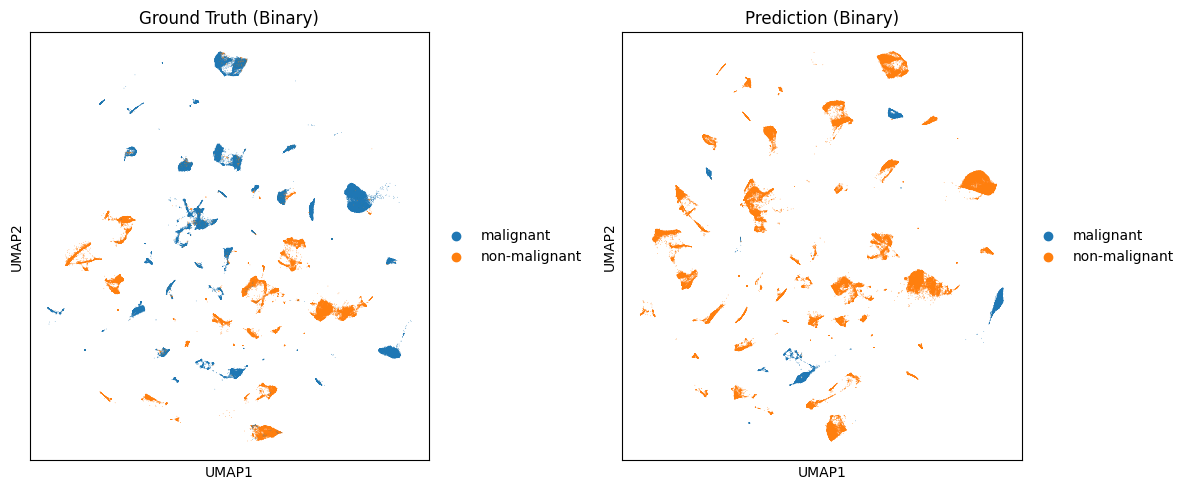

In [7]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/mLLMCellType/mllm_top_models.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
prediction_data = sc.read_h5ad(prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

prediction_data = map_cell_types_to_binary(
    adata=prediction_data,
    cell_type_col="gpt4o_cell_type",
    malignant_types=[ #'epithelial cell', 'epithelial cells', 
                    'proliferating cell', 'proliferating cells']
)

# Use a unique path for this specific dataset combination
umap_path = "../umap_embeddings/biomaster_dataset"

metrics = evaluate_binary_classification(
        prediction_data=prediction_data,
        ground_truth=ground_truth,
        prediction_col="gpt4o_cell_type_binary",  # Change this to match your prediction column
        truth_col="malignancy",
        load_path=umap_path,
        save_path=umap_path,
        compute_umap=True,  # Set to False if you don't need UMAP
        plot_umap=True  # Set to False if you don't want to plot
    )

Before classification: 138727 cells total

Binary category distribution:
gpt4o_cell_type_binary
non-malignant    135550
malignant          3177
Name: count, dtype: int64
Malignant cells: 3177 (2.29%)
Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[ 3176 82573]
 [    1 52977]]
Accuracy : 0.4048
Precision: 0.9997
Recall   : 0.0370
F1 Score : 0.0714

Classification Report:
               precision    recall  f1-score   support

    malignant       1.00      0.04      0.07     85749
non-malignant       0.39      1.00      0.56     52978

     accuracy                           0.40    138727
    macro avg       0.70      0.52      0.32    138727
 weighted avg       0.77      0.40      0.26    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_321557/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_321557/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


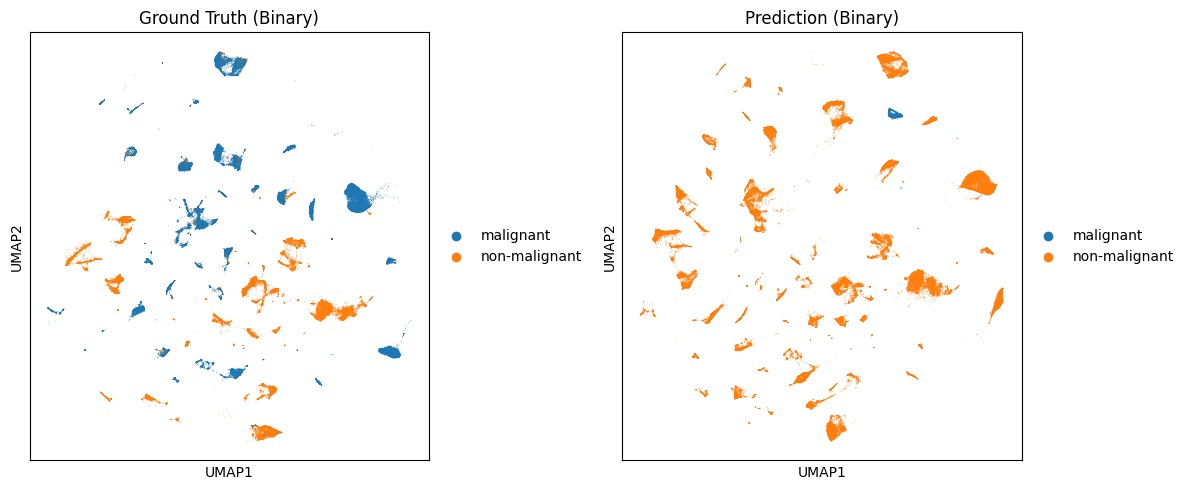

In [8]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/mLLMCellType/mllm_free_models.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
prediction_data = sc.read_h5ad(prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

prediction_data = map_cell_types_to_binary(
    adata=prediction_data,
    cell_type_col="gpt4o_cell_type",
    malignant_types=[#'epithelial cell', 'epithelial cells', 
                    'proliferating cell', 'proliferating cells']
)

# Use a unique path for this specific dataset combination
umap_path = "../umap_embeddings/biomaster_dataset"

metrics = evaluate_binary_classification(
        prediction_data=prediction_data,
        ground_truth=ground_truth,
        prediction_col="gpt4o_cell_type_binary",  # Change this to match your prediction column
        truth_col="malignancy",
        load_path=umap_path,
        save_path=umap_path,
        compute_umap=True,  # Set to False if you don't need UMAP
        plot_umap=True  # Set to False if you don't want to plot
    )

# Biomni

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[34746 51003]
 [25679 27299]]
Accuracy : 0.4472
Precision: 0.5750
Recall   : 0.4052
F1 Score : 0.4754

Classification Report:
               precision    recall  f1-score   support

    malignant       0.58      0.41      0.48     85749
non-malignant       0.35      0.52      0.42     52978

     accuracy                           0.45    138727
    macro avg       0.46      0.46      0.45    138727
 weighted avg       0.49      0.45      0.45    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_161342/1573674065.py:112: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_161342/1573674065.py:113: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded with consistent cell ordering


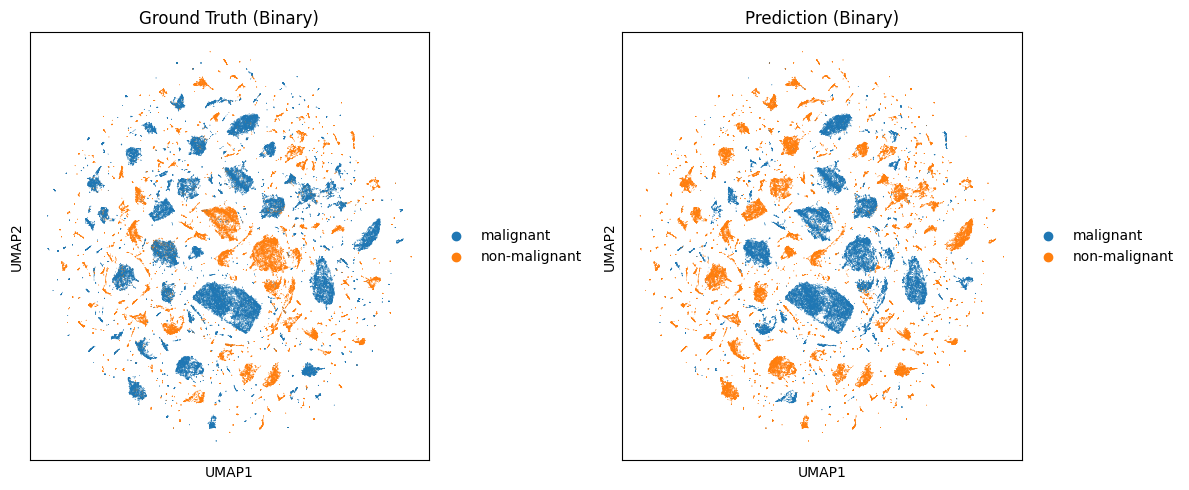


Evaluation metrics:
accuracy: 0.4472
precision: 0.5750
recall: 0.4052
f1: 0.4754
confusion_matrix:
[[34746 51003]
 [25679 27299]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [28]:
"""
placeholder
"""


# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni1.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignancy",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[10742 75007]
 [ 3460 49518]]
Accuracy : 0.4344
Precision: 0.7564
Recall   : 0.1253
F1 Score : 0.2149

Classification Report:
               precision    recall  f1-score   support

    malignant       0.76      0.13      0.21     85749
non-malignant       0.40      0.93      0.56     52978

     accuracy                           0.43    138727
    macro avg       0.58      0.53      0.39    138727
 weighted avg       0.62      0.43      0.35    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_161342/1573674065.py:112: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_161342/1573674065.py:113: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded with consistent cell ordering


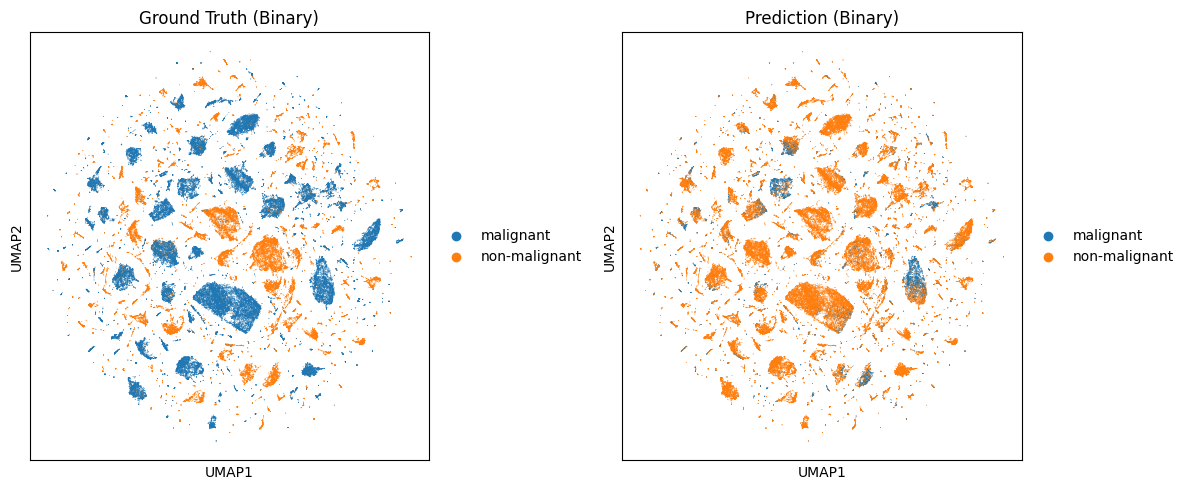


Evaluation metrics:
accuracy: 0.4344
precision: 0.7564
recall: 0.1253
f1: 0.2149
confusion_matrix:
[[10742 75007]
 [ 3460 49518]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [25]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni2_improved.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)


# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignancy",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path="../umap_embeddings/biomaster_dataset",
    save_path="../umap_embeddings/biomaster_dataset",
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[63712 22037]
 [41736 11242]]
Accuracy : 0.5403
Precision: 0.6042
Recall   : 0.7430
F1 Score : 0.6665

Classification Report:
               precision    recall  f1-score   support

    malignant       0.60      0.74      0.67     85749
non-malignant       0.34      0.21      0.26     52978

     accuracy                           0.54    138727
    macro avg       0.47      0.48      0.46    138727
 weighted avg       0.50      0.54      0.51    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_335743/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_335743/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


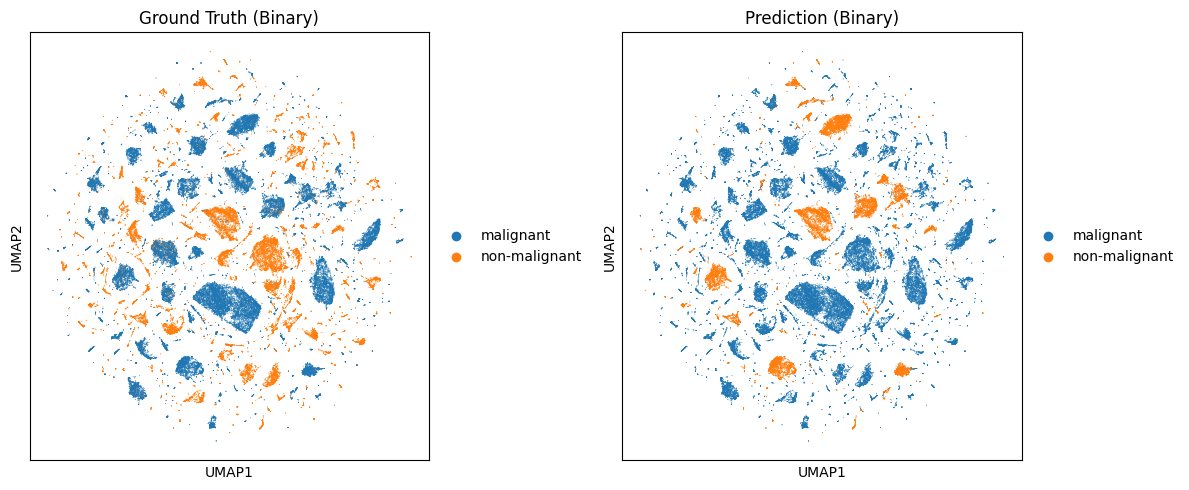


Evaluation metrics:
accuracy: 0.5403
precision: 0.6042
recall: 0.7430
f1: 0.6665
confusion_matrix:
[[63712 22037]
 [41736 11242]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [10]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni3.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignancy",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[12745 73004]
 [21937 31041]]
Accuracy : 0.3156
Precision: 0.3675
Recall   : 0.1486
F1 Score : 0.2117

Classification Report:
               precision    recall  f1-score   support

    malignant       0.37      0.15      0.21     85749
non-malignant       0.30      0.59      0.40     52978

     accuracy                           0.32    138727
    macro avg       0.33      0.37      0.30    138727
 weighted avg       0.34      0.32      0.28    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_335743/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_335743/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


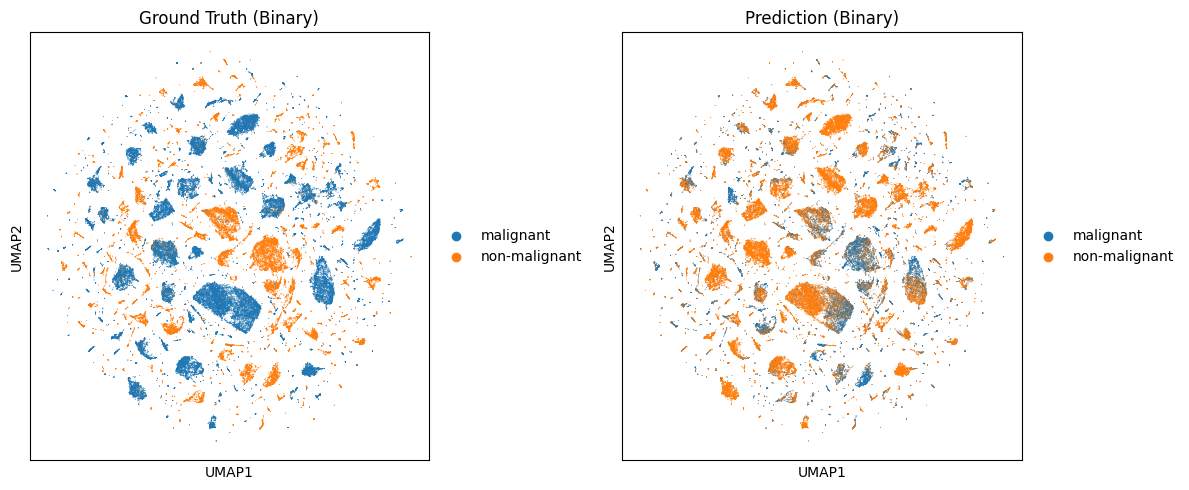


Evaluation metrics:
accuracy: 0.3156
precision: 0.3675
recall: 0.1486
f1: 0.2117
confusion_matrix:
[[12745 73004]
 [21937 31041]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [15]:
"""
placeholder
"""


# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni4.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignant_classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[20899 64850]
 [ 7965 45013]]
Accuracy : 0.4751
Precision: 0.7241
Recall   : 0.2437
F1 Score : 0.3647

Classification Report:
               precision    recall  f1-score   support

    malignant       0.72      0.24      0.36     85749
non-malignant       0.41      0.85      0.55     52978

     accuracy                           0.48    138727
    macro avg       0.57      0.55      0.46    138727
 weighted avg       0.60      0.48      0.44    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_335743/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_335743/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


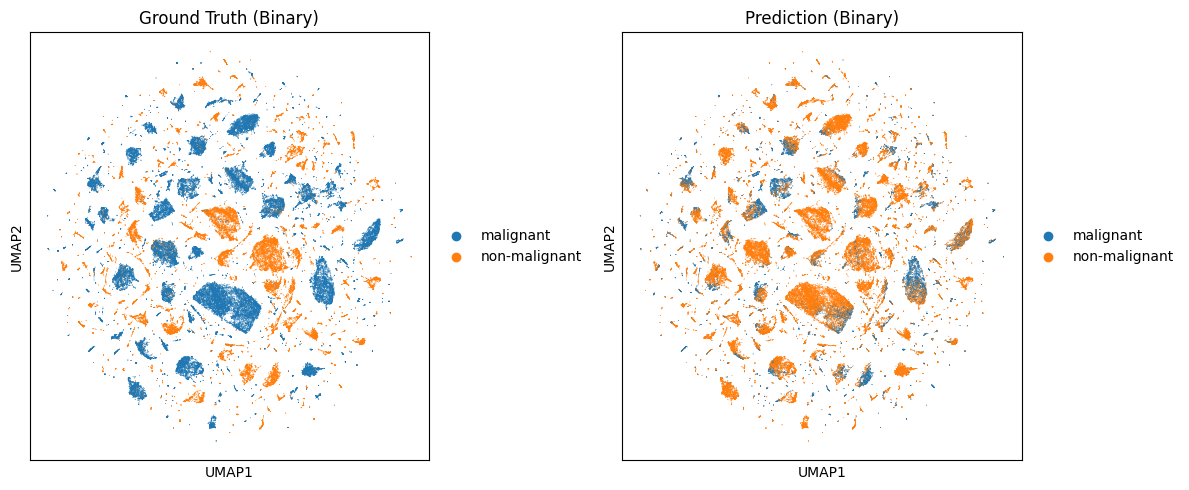


Evaluation metrics:
accuracy: 0.4751
precision: 0.7241
recall: 0.2437
f1: 0.3647
confusion_matrix:
[[20899 64850]
 [ 7965 45013]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [19]:
"""
placeholder
"""


# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni5.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[ 1418 84331]
 [42975 10003]]
Accuracy : 0.0823
Precision: 0.0319
Recall   : 0.0165
F1 Score : 0.0218

Classification Report:
               precision    recall  f1-score   support

    malignant       0.03      0.02      0.02     85749
non-malignant       0.11      0.19      0.14     52978

     accuracy                           0.08    138727
    macro avg       0.07      0.10      0.08    138727
 weighted avg       0.06      0.08      0.07    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_111628/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_111628/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


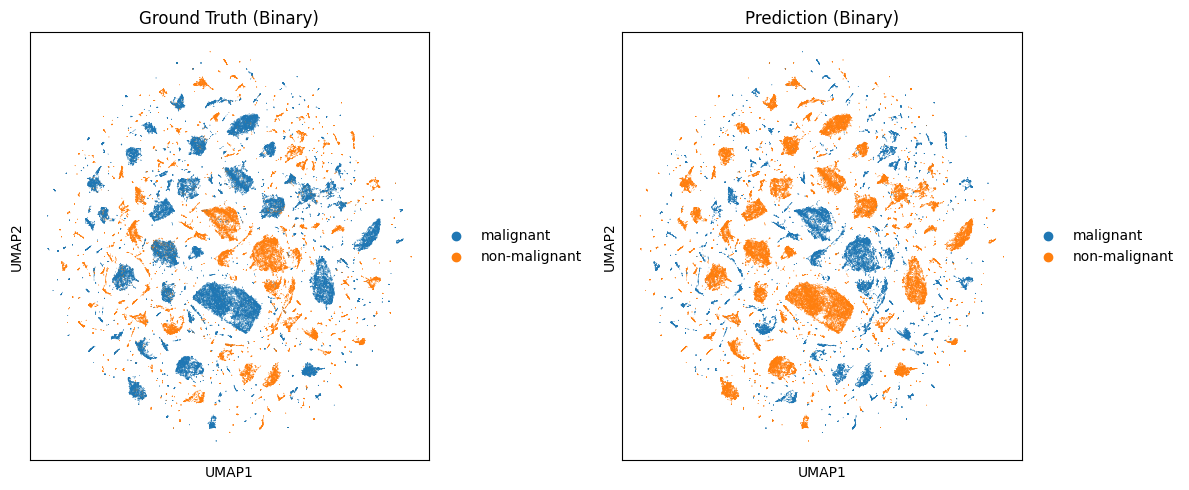


Evaluation metrics:
accuracy: 0.0823
precision: 0.0319
recall: 0.0165
f1: 0.0218
confusion_matrix:
[[ 1418 84331]
 [42975 10003]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [5]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni/biomni6.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignant_status",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[60477 25272]
 [44204  8774]]
Accuracy : 0.4992
Precision: 0.5777
Recall   : 0.7053
F1 Score : 0.6352

Classification Report:
               precision    recall  f1-score   support

    malignant       0.58      0.71      0.64     85749
non-malignant       0.26      0.17      0.20     52978

     accuracy                           0.50    138727
    macro avg       0.42      0.44      0.42    138727
 weighted avg       0.46      0.50      0.47    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_111628/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_111628/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


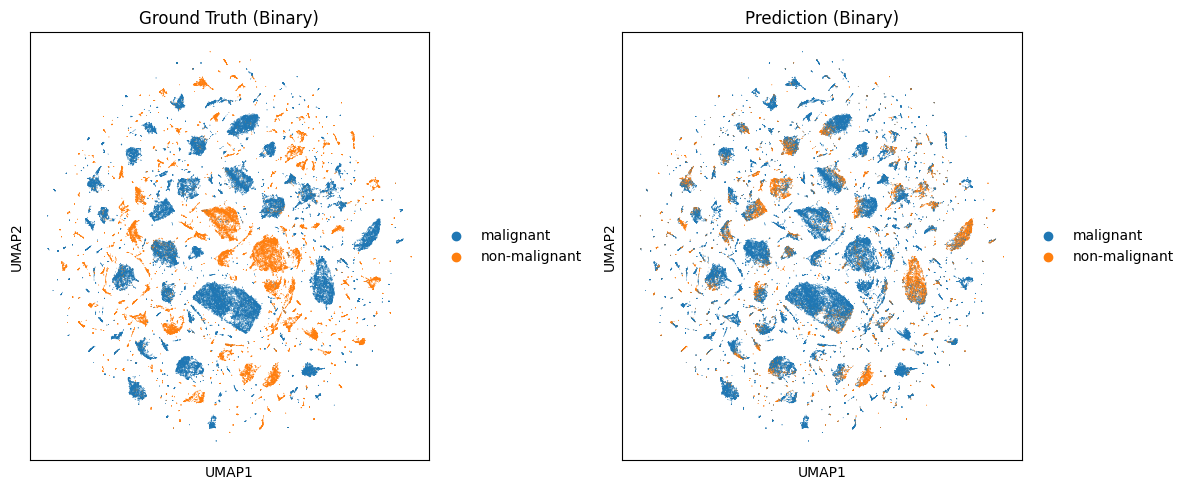


Evaluation metrics:
accuracy: 0.4992
precision: 0.5777
recall: 0.7053
f1: 0.6352
confusion_matrix:
[[60477 25272]
 [44204  8774]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [6]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni/biomni7.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



# celltypeagent

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[29300 56449]
 [23376 29602]]
Accuracy : 0.4246
Precision: 0.5562
Recall   : 0.3417
F1 Score : 0.4233

Classification Report:
               precision    recall  f1-score   support

    malignant       0.56      0.34      0.42     85749
non-malignant       0.34      0.56      0.43     52978

     accuracy                           0.42    138727
    macro avg       0.45      0.45      0.42    138727
 weighted avg       0.48      0.42      0.42    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_1961995/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_1961995/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


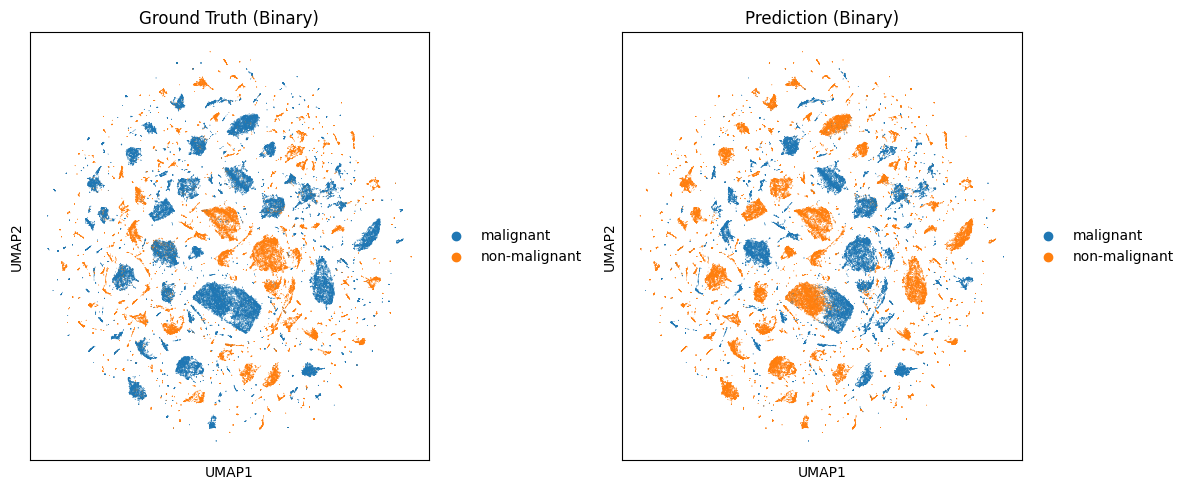


Evaluation metrics:
accuracy: 0.4246
precision: 0.5562
recall: 0.3417
f1: 0.4233
confusion_matrix:
[[29300 56449]
 [23376 29602]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [6]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/celltypeagnet_processing/dataset_restricted_processed.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="cell_type_pred",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")

# cassia

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[58199 27550]
 [30031 22947]]
Accuracy : 0.5849
Precision: 0.6596
Recall   : 0.6787
F1 Score : 0.6690

Classification Report:
               precision    recall  f1-score   support

    malignant       0.66      0.68      0.67     85749
non-malignant       0.45      0.43      0.44     52978

     accuracy                           0.58    138727
    macro avg       0.56      0.56      0.56    138727
 weighted avg       0.58      0.58      0.58    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_78615/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_78615/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


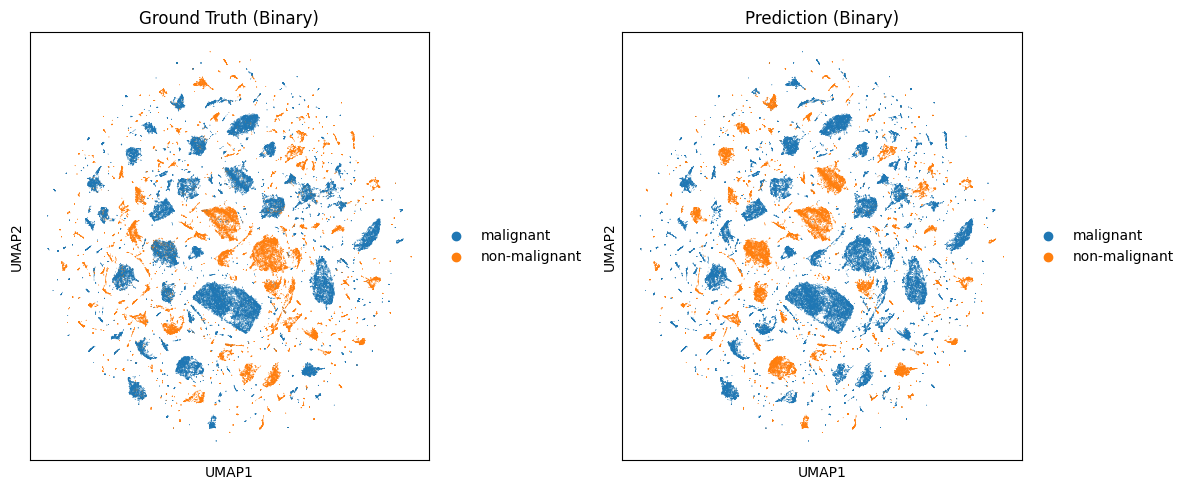


Evaluation metrics:
accuracy: 0.5849
precision: 0.6596
recall: 0.6787
f1: 0.6690
confusion_matrix:
[[58199 27550]
 [30031 22947]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [4]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/cassia_preprocessing/dataset_labelled_cassia.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignancy",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")

# scarcoma 

# biomaster

Found 16125 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[    0 12694]
 [    0  3431]]
Accuracy : 0.2128
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

    malignant       0.00      0.00      0.00     12694
non-malignant       0.21      1.00      0.35      3431

     accuracy                           0.21     16125
    macro avg       0.11      0.50      0.18     16125
 weighted avg       0.05      0.21      0.07     16125

Computing unified UMAP for both datasets...


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Using 2000 common genes for unified UMAP


/tmp/ipykernel_111628/2042606192.py:190: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined = pred_copy.concatenate(truth_copy)


Computing PCA on combined dataset...
Computing UMAP embedding...


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_111628/2042606192.py:228: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  pred_copy.obsm['X_umap'] = pred_umap
/tmp/ipykernel_111628/2042606192.py:229: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  truth_copy.obsm['X_umap'] = truth_umap


Unified UMAP embedding complete
UMAP embeddings saved to ../umap_embeddings/sarcoma


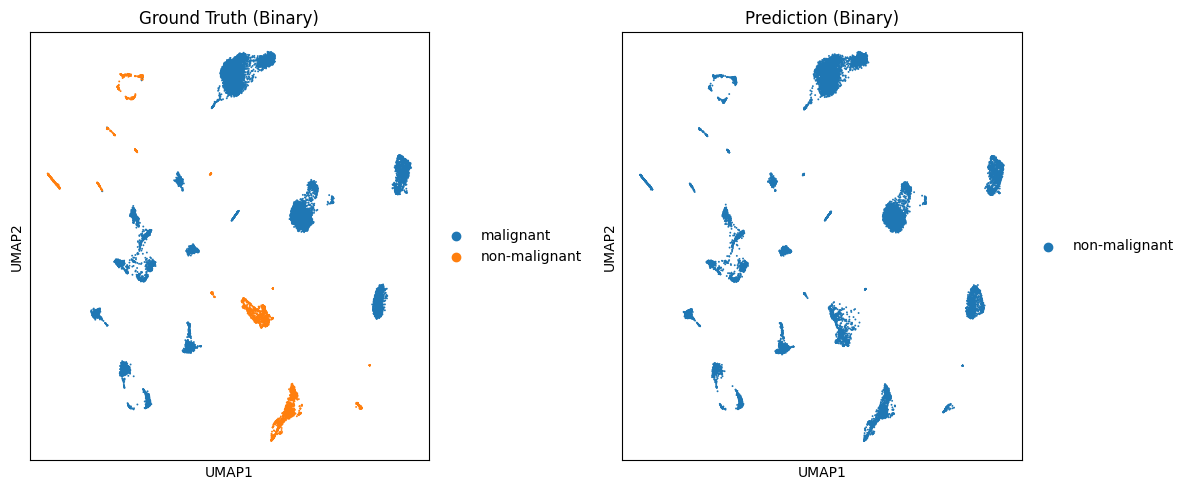


Evaluation metrics:
accuracy: 0.2128
precision: 0.0000
recall: 0.0000
f1: 0.0000
confusion_matrix:
[[    0 12694]
 [    0  3431]]
Found 16125 common cells between datasets

After alignment: 16125 common cells found


In [55]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/biomaster/output/o3_sarcoma/cell_classification.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/sarcoma_dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/sarcoma"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="cell_classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True      # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



# biomni

In [3]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni/biomni8.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/sarcoma_dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/sarcoma"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="cell_classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=False,  # Set to True if you want UMAP visualization
    plot_umap=False  # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")



Found 16080 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[ 1600 11049]
 [ 2142  1289]]
Accuracy : 0.1797
Precision: 0.4276
Recall   : 0.1265
F1 Score : 0.1952

Classification Report:
               precision    recall  f1-score   support

    malignant       0.43      0.13      0.20     12649
non-malignant       0.10      0.38      0.16      3431

     accuracy                           0.18     16080
    macro avg       0.27      0.25      0.18     16080
 weighted avg       0.36      0.18      0.19     16080


Evaluation metrics:
accuracy: 0.1797
precision: 0.4276
recall: 0.1265
f1: 0.1952
confusion_matrix:
[[ 1600 11049]
 [ 2142  1289]]
Found 16080 common cells between datasets

After alignment: 16080 common cells found


# biomni with expert clustering

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['malignant' 'non-malignant']

Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[51162 34587]
 [ 2410 50568]]
Accuracy : 0.7333
Precision: 0.9550
Recall   : 0.5966
F1 Score : 0.7344

Classification Report:
               precision    recall  f1-score   support

    malignant       0.96      0.60      0.73     85749
non-malignant       0.59      0.95      0.73     52978

     accuracy                           0.73    138727
    macro avg       0.77      0.78      0.73    138727
 weighted avg       0.82      0.73      0.73    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/tmp/ipykernel_1343855/2042606192.py:107: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  prediction_data.obsm['X_umap'] = pred_umap
/tmp/ipykernel_1343855/2042606192.py:108: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  ground_truth.obsm['X_umap'] = truth_umap


UMAP embeddings successfully loaded


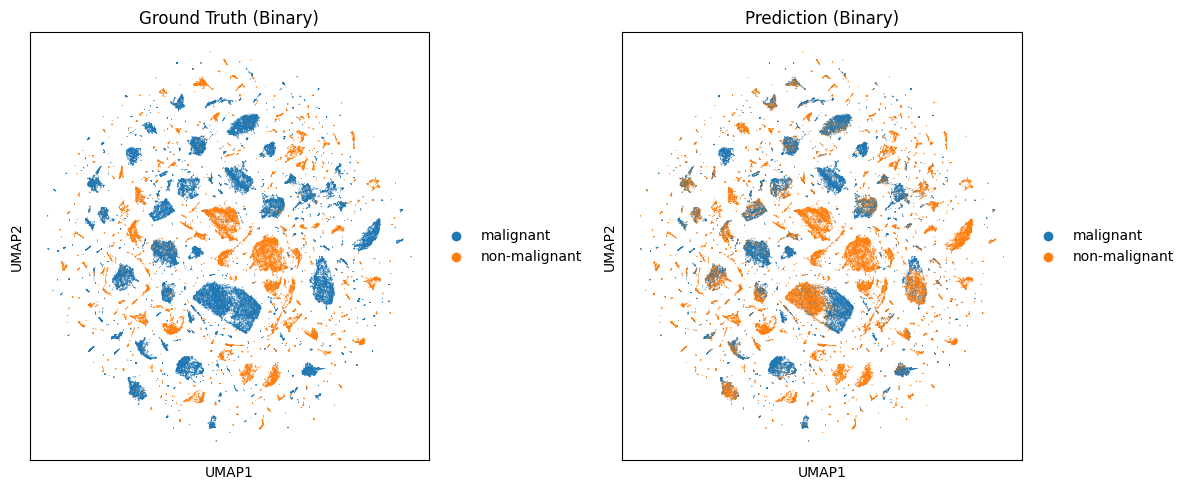


Evaluation metrics:
accuracy: 0.7333
precision: 0.9550
recall: 0.5966
f1: 0.7344
confusion_matrix:
[[51162 34587]
 [ 2410 50568]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [8]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/evaluator/biomni/biomni_clustered.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="malignancy_classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True  # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")

# biomaster with cluster

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['non-malignant']


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[    0 85749]
 [    0 52978]]
Accuracy : 0.3819
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

    malignant       0.00      0.00      0.00     85749
non-malignant       0.38      1.00      0.55     52978

     accuracy                           0.38    138727
    macro avg       0.19      0.50      0.28    138727
 weighted avg       0.15      0.38      0.21    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

UMAP embeddings successfully loaded


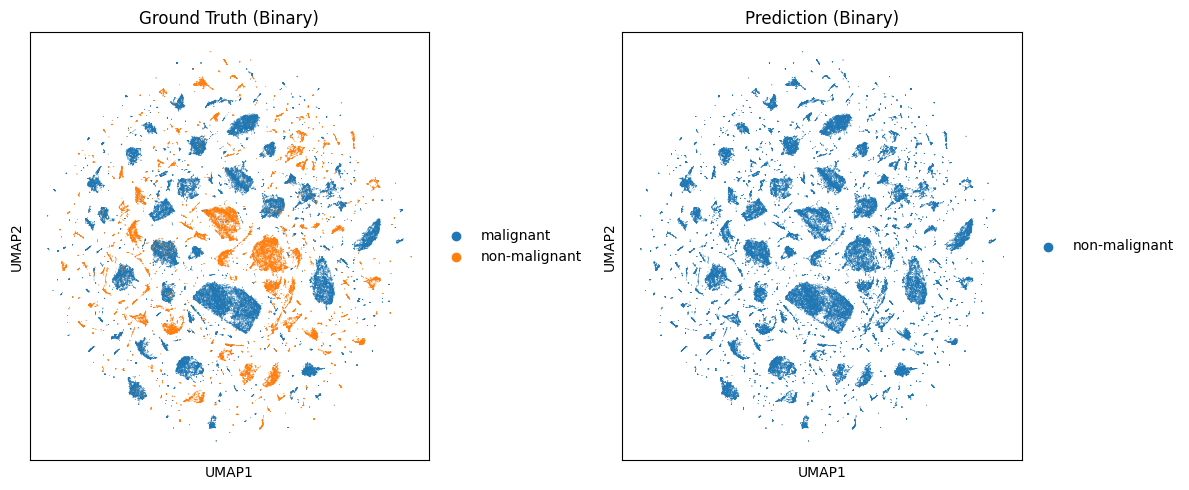


Evaluation metrics:
accuracy: 0.3819
precision: 0.0000
recall: 0.0000
f1: 0.0000
confusion_matrix:
[[    0 85749]
 [    0 52978]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [13]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/biomaster/output/o3_with_cluster/classified_dataset.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="cell_class",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True  # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")

Found 138727 common cells between datasets
True labels: ['malignant' 'non-malignant']
Pred labels: ['non-malignant']


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Binary Classification Results (malignant vs non-malignant):

Confusion Matrix:
 [[    0 85749]
 [    0 52978]]
Accuracy : 0.3819
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

    malignant       0.00      0.00      0.00     85749
non-malignant       0.38      1.00      0.55     52978

     accuracy                           0.38    138727
    macro avg       0.19      0.50      0.28    138727
 weighted avg       0.15      0.38      0.21    138727

Loading UMAP embeddings from ../umap_embeddings/biomaster_dataset


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

Computing unified UMAP for both datasets...
Using 33541 common genes for unified UMAP


/tmp/ipykernel_1359262/2042606192.py:190: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined = pred_copy.concatenate(truth_copy)


Computing PCA on combined dataset...
Computing UMAP embedding...


/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cs/student/projects2/aisd/2024/shekchu/miniconda/envs/dataset/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1359262/2042606192.py:228: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  pred_copy.obsm['X_umap'] = pred_umap
/tmp/ipykernel_1359262/2042606192.py:229: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  truth_copy.obsm['X_umap'] = truth_umap


Unified UMAP embedding complete
UMAP embeddings saved to ../umap_embeddings/biomaster_dataset


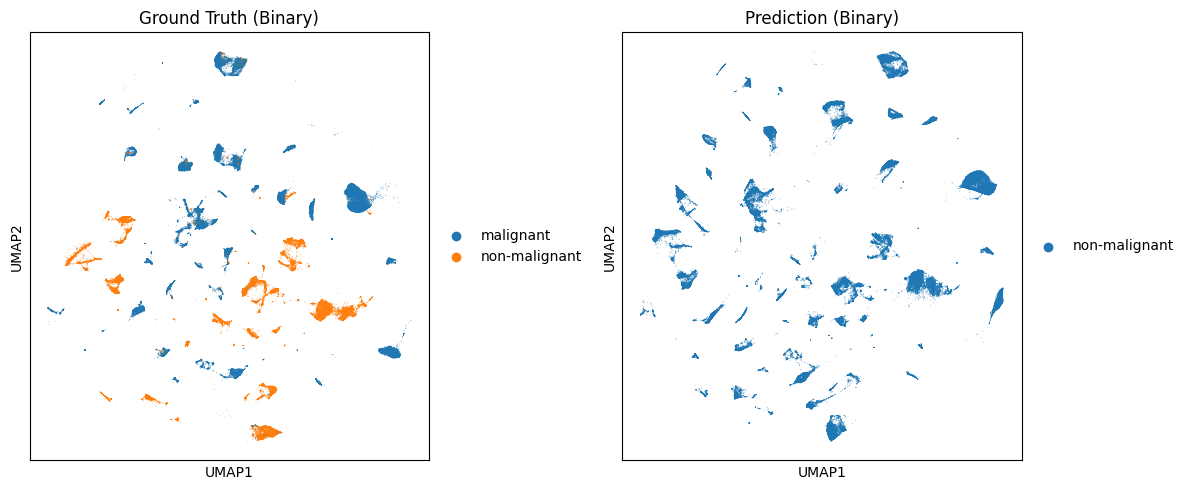


Evaluation metrics:
accuracy: 0.3819
precision: 0.0000
recall: 0.0000
f1: 0.0000
confusion_matrix:
[[    0 85749]
 [    0 52978]]
Found 138727 common cells between datasets

After alignment: 138727 common cells found


In [23]:
# Example of how to use the converted h5ad file with the evaluation function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'

# File paths
converted_prediction_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/biomaster/output/o3_with_cluster2/final_annotated_adata.h5ad"
ground_truth_file = "/cs/student/projects2/aisd/2024/shekchu/projects/cell_agents/remove_label/dataset_restricted_with_labels.h5ad"

# Load data
converted_prediction_data = sc.read_h5ad(converted_prediction_file)
ground_truth = sc.read_h5ad(ground_truth_file)

umap_path = "../umap_embeddings/biomaster_dataset"

# Run evaluation using the malignancy column we created
metrics = evaluate_binary_classification(
    prediction_data=converted_prediction_data,
    ground_truth=ground_truth,
    prediction_col="classification",  # Use our new mapped column
    truth_col="malignancy",       # The ground truth column
    pos_label='malignant',
    neg_label='non-malignant',
    load_path=umap_path,
    save_path=umap_path,
    compute_umap=True,  # Set to True if you want UMAP visualization
    plot_umap=True  # Set to True if you want UMAP visualization
)

print("\nEvaluation metrics:")
for key, value in metrics.items():
    if key != 'confusion_matrix':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}:\n{value}")

# You can also analyze the alignment between datasets
prediction_subset, ground_truth_subset = align_datasets(converted_prediction_data, ground_truth)
print(f"\nAfter alignment: {len(prediction_subset)} common cells found")